# DatafestAfrica ML Hackathon Submission for Analytical Minds

### Zion Oluwasegun, Neto Anyama and Oladimeji Olaniyan



In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import lightgbm
from lightgbm import LGBMClassifier

# set plot style
sns.set_theme(style = 'darkgrid')
sns.set_context('paper')
base_color = sns.color_palette()[0]

%matplotlib inline

# To suppress all warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'lightgbm'

## Table of Contents

<ul>
<li><a href="#intro">Abstract</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#ml">Machine Learning Model</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>


<a id='intro'></a>

## Abstract
 The aim of this project is to train a Machine Learning model to help a Financial Industry predict who is likely to complete an E-process application.

<a id='wrangling'></a>
## Data  Wrangling

To gather the data used, we downloaded the train and test datasets from [here](https://www.kaggle.com/competitions/datafestafrica-ml-hackathon/data). Afterwards, we read the csv file using pandas.


In [2]:
# downloading the datasets by importing them using the pandas library
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

We will be performing our wrangling on the train dataset.

### Assessing

 We employed visual and programmatic assessments to review the dataset and check for errors. Programmatic methods we used were: `info`, `duplicated`, `head`, `describe`.

In [3]:
# creating a simple function to return basic information on the dataset
def info(df):
    print(df.shape),
    print('*' *40),
    print(df.info())
    print('*' *40)
    print(df.nunique())
    
info(df_train)
df_train.sample(5)

(12516, 21)
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entry_id              12516 non-null  int64  
 1   age                   12516 non-null  int64  
 2   pay_schedule          12516 non-null  object 
 3   home_owner            12516 non-null  int64  
 4   income                12516 non-null  int64  
 5   months_employed       12516 non-null  int64  
 6   years_employed        12516 non-null  int64  
 7   current_address_year  12516 non-null  int64  
 8   personal_account_m    12516 non-null  int64  
 9   personal_account_y    12516 non-null  int64  
 10  has_debt              12516 non-null  int64  
 11  amount_requested      12516 non-null  int64  
 12  risk_score            12516 non-null  int64  
 13  risk_score_2          12516 non-null  float64
 14  risk_score_3     

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
4590,8823195,47,bi-weekly,0,4070,1,5,6,3,6,...,500,41750,0.307236,0.876526,0.504627,0.751078,0.586747,0.486747,9,0
11246,5305529,42,monthly,1,6730,0,6,10,6,4,...,2800,80750,0.824238,0.904673,0.640654,0.700397,0.669352,0.769352,3,1
9755,4735178,56,monthly,0,3090,0,6,2,3,2,...,600,74850,0.730770,0.793466,0.549562,0.604988,0.475722,0.575722,2,1
10621,6407288,63,bi-weekly,0,1625,1,2,2,5,1,...,400,50400,0.705397,0.881128,0.673633,0.875690,0.832834,0.732834,5,0
3789,4759038,45,bi-weekly,0,2665,0,3,5,4,7,...,1150,61100,0.610519,0.910172,0.475336,0.602884,0.625195,0.525195,10,0


In [4]:
# creating a dataframe to house key numerical variables in the dataset 
num_vars = pd.DataFrame()
num_vars['age'] = df_train['age']
num_vars['income'] = df_train['income']
num_vars['amount_requested'] = df_train['amount_requested']
num_vars['risk_score'] = df_train['risk_score']

In [5]:
# this returns summary statistics on key numerical variables in the dataset.
num_vars.describe()

,age,income,amount_requested,risk_score
count,12516.000000,12516.000000,12516.000000,12516.000000
mean,43.026766,3654.110658,950.251518,61133.401246
std,11.865891,1508.072163,706.915146,15396.809340
min,18.000000,905.000000,350.000000,2100.000000
25%,34.000000,2575.000000,600.000000,49450.000000
50%,42.000000,3255.000000,700.000000,61200.000000
75%,51.000000,4661.250000,1100.000000,72750.000000
max,96.000000,9985.000000,10200.000000,99750.000000


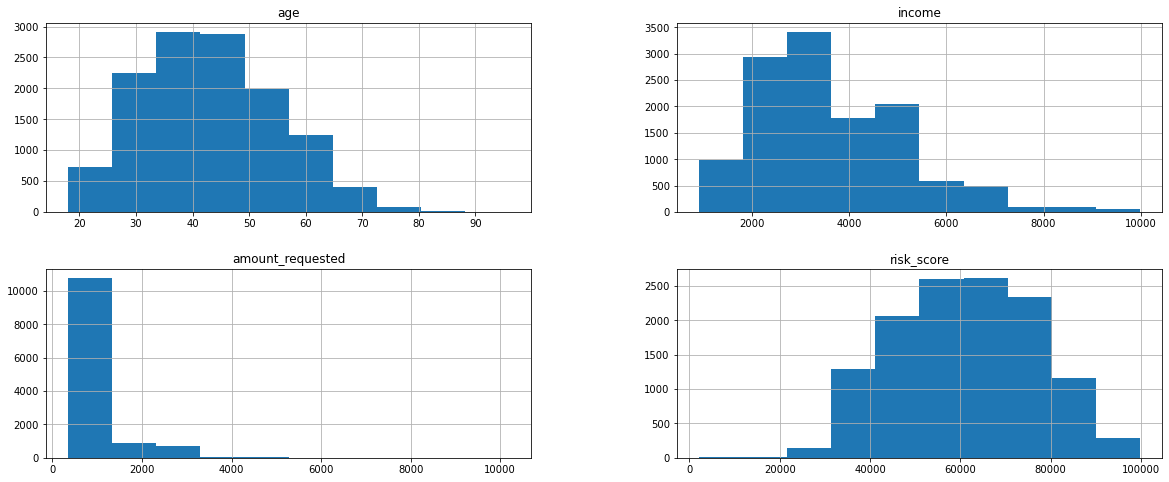

In [6]:
# creating a simple visualization of these numerical variables
num_vars.hist(figsize=(20, 8));

### Quick Observations

- Most customers appear to be middle aged, as the mean age is 43 years.
- The distribution of income is slightly skewed to the right and has a long tail, suggesting potential ouliers.
- There is some imbalance in the distribution of amount_requested.
- The risk_score is slightly skewed to the left

In [7]:
# checking key columns for dulicate entries
df_train.Entry_id.duplicated().value_counts()

False    12510
True         6
Name: Entry_id, dtype: int64

### Issues

1. Duplicate entries in the `Entry_id` column
2. The `months_employed` and `years_employed` columns should be merged into one.
3. The `personal_account_m` and `personal_account_y` columns should be merged into one.
4. The datatype of the `entry_id` column needed to be changed to object.
5. In `home_owner`, `has_debt`, and `e_signed` columns, we needed to replace 0 and 1 with no and yes respectively.
6. risk_score column should be a float and not an integer.

### Cleaning

Before we commence cleaning, it is best to create a copy of the dataset upon which the cleaning will be done.

In [8]:
df_train_eda = df_train.copy()

#### Issue 1:
Duplicate entries in the Entry_id column

#### Define: 
The entry id column contains some duplicate entries that need to be dropped.

#### Code 

In [9]:
#test
sum(df_train_eda.Entry_id.duplicated())

6

In [10]:
df_train_eda.drop_duplicates(subset= 'Entry_id', inplace = True)

In [11]:
# confirmation 
sum(df_train_eda.Entry_id.duplicated())

0

#### Issue 2: 
The months_employed and years_employed columns should be merged into one column.

#### Define:
The months_employed and years_employed columns should be merged to make it easier to work with them. This column will be represented in months

#### Code

In [12]:
# test
df_train_eda.sample(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
4928,2865882,19,weekly,0,3245,0,4,3,1,5,...,1000,36300,0.727911,0.950653,0.588519,0.917357,0.748769,0.548769,7,0
237,2778619,39,weekly,0,1660,9,4,2,4,3,...,500,34650,0.541355,0.884461,0.674737,0.793233,0.500755,0.800755,10,1
1247,7807172,42,bi-weekly,1,2579,4,4,1,1,4,...,900,50250,0.550836,0.868693,0.403718,0.663956,0.469954,0.469954,6,0


In [13]:
df_train_eda['total_months_employed'] = (df_train_eda['years_employed']*12) + df_train_eda['months_employed']

In [14]:
# confirmation
df_train_eda.sample(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,total_months_employed
12515,1498559,29,weekly,1,2665,0,4,10,4,1,...,64950,0.720889,0.874372,0.505565,0.631619,0.846163,0.846163,4,1,48
11620,5950792,47,bi-weekly,0,3060,5,1,1,2,4,...,77200,0.601427,0.860859,0.660260,0.613357,0.706565,0.506565,7,0,17
471,5483512,56,weekly,1,5000,0,3,1,6,2,...,58950,0.773954,0.877693,0.644469,0.847034,0.606736,0.406736,4,0,36


#### Issue 3: 
The personal_account_m and personal_account_y columns should be merged into one.


#### Define:
The personal_account_m and personal_account_y columns should be merged to make it easier to work with them. This column will be represented in months

#### Code

In [15]:
# test
df_train_eda.sample(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,total_months_employed
5496,4366560,41,bi-weekly,0,2170,0,6,2,3,2,...,34350,0.617172,0.864316,0.505323,0.656251,0.722883,0.622883,10,1,72
11865,1806499,35,bi-weekly,1,1925,0,3,1,5,2,...,79800,0.642523,0.859714,0.653797,0.782189,0.761382,0.461382,5,0,36
6425,9123155,42,semi-monthly,1,2045,0,3,1,4,2,...,71050,0.808053,0.921395,0.662679,0.896744,0.713696,0.613696,5,1,36


In [16]:
df_train_eda['personal_account_duration'] = (df_train_eda['personal_account_y']*12) + df_train_eda['personal_account_m']

In [17]:
# confirmation
df_train_eda.sample(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,total_months_employed,personal_account_duration
6013,3167513,52,weekly,1,3165,7,1,2,7,4,...,0.664219,0.910240,0.666370,0.848403,0.406619,0.506619,10,1,19,55
12481,7997931,65,semi-monthly,0,4615,0,3,1,4,1,...,0.750322,0.903517,0.597211,0.608444,0.698397,0.698397,8,0,36,16
7668,1930975,54,bi-weekly,1,3005,0,2,3,7,3,...,0.706942,0.890061,0.553328,0.660309,0.629831,0.629831,11,0,24,43


#### Issue 4:
The datatype of the `entry_id` column needed to be changed to object.

#### Define:
Changing the datatype of entry_id from integer to string.

#### Code

In [18]:
#test
df_train_eda.Entry_id.info()

<class 'pandas.core.series.Series'>
Int64Index: 12510 entries, 0 to 12515
Series name: Entry_id
Non-Null Count  Dtype
--------------  -----
12510 non-null  int64
dtypes: int64(1)
memory usage: 195.5 KB


In [19]:
df_train_eda = df_train_eda.astype({'Entry_id':'object'})

In [20]:
#confirmation
df_train_eda.Entry_id.info()

<class 'pandas.core.series.Series'>
Int64Index: 12510 entries, 0 to 12515
Series name: Entry_id
Non-Null Count  Dtype 
--------------  ----- 
12510 non-null  object
dtypes: object(1)
memory usage: 195.5+ KB


#### Issue 5:
In `home_owner`, `has_debt`, and `e_signed` columns, we needed to replace 0 and 1 with yes and no respectively.

#### Define:
Replacing 0 and 1 in these 2 columns with yes or no

#### Code

In [21]:
#test
df_train_eda.sample(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,total_months_employed,personal_account_duration
6203,2324856,51,weekly,0,2610,5,3,2,7,2,...,0.603768,0.819290,0.773481,0.791970,0.696943,0.496943,13,0,41,31
8263,9204962,34,bi-weekly,0,3875,0,6,6,2,6,...,0.770100,0.869882,0.414789,0.601676,0.599700,0.499700,4,1,72,74
7428,2690625,30,bi-weekly,0,3710,0,1,1,9,2,...,0.757824,0.904640,0.599967,0.845246,0.753587,0.853587,3,0,12,33


In [22]:
df_train_eda.home_owner.replace({0:'No', 1:'Yes'}, inplace=True)
df_train_eda.has_debt.replace({0:'No', 1:'Yes'}, inplace=True)
df_train_eda.e_signed.replace({0:'No', 1:'Yes'}, inplace=True)

In [23]:
#confirmation
df_train_eda.sample(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,total_months_employed,personal_account_duration
2831,4848509,31,bi-weekly,No,3700,0,5,3,5,2,...,0.780984,0.980966,0.741341,0.846847,0.864408,0.864408,2,No,60,29
4826,6093196,27,semi-monthly,Yes,2715,1,3,1,4,3,...,0.700813,0.876538,0.573224,0.695368,0.538012,0.538012,3,No,37,40
9169,4641390,52,weekly,Yes,3650,0,4,3,1,3,...,0.707103,0.823891,0.777461,0.637282,0.438897,0.638897,4,Yes,48,37


#### Issue 6:
`risk_score` column should be a float and not an integer.

#### Define:
This is to make the risk_score columns match up

In [24]:
#test
df_train_eda.risk_score.sample(3)

313     56050
5152    59400
185     48250
Name: risk_score, dtype: int64

In [25]:
df_train_eda['risk_score_n'] = (df_train_eda.risk_score / 100000)

In [26]:
#confirmation
df_train_eda.risk_score_n.sample(3)

9871    0.7840
9581    0.8995
2392    0.6600
Name: risk_score_n, dtype: float64

### Structure of the dataset

The train dataset intially contained 12,516 rows, and 21 columns. After assessing and cleaning the data, it now contains 12,510 rows and 23 columns.

<a id='eda'></a>
## <u>Exploratory Data Analysis.

In this section of the project, we are going to be exploring multiple variables from the train dataset.



## Univariate Exploration

### Distribution of ages in the dataset.

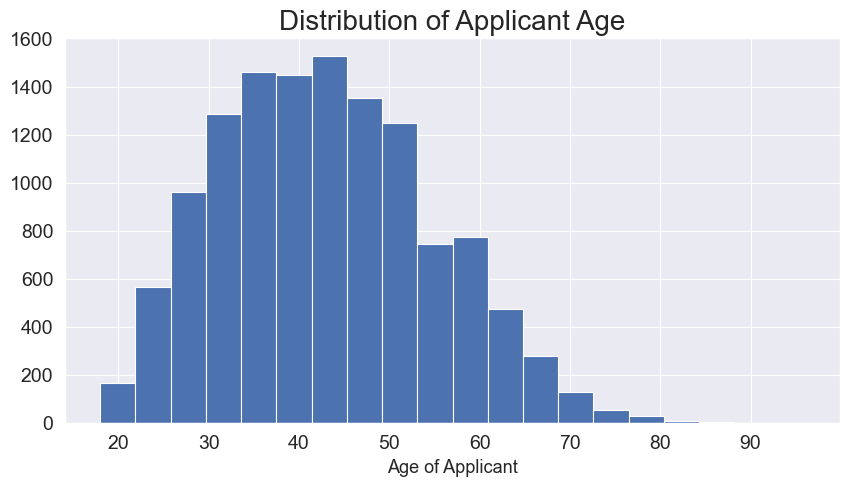

In [83]:
plt.figure(figsize=(10,5))
plt.hist(df_train_eda.age, color = base_color, bins = 20);
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Age of Applicant', fontsize=13)
plt.title('Distribution of Applicant Age', fontsize=20);

The age distribution is slightly skewed right suggesting that there are more younger to middle aged customers i.e 30 to 40, than there are older customers i.e 50 to 90. 

To get a clearer picture of the distribution of ages, we will place them into age brackets.

In [84]:
def prop_(x):
    
    '''To calculate proportions of values in a column.
    x will be df.col or df['col']'''
    
    max_var_count = x.value_counts()[0]
    var_sum = x.value_counts().sum()
    max_prop = max_var_count/var_sum
    tick_props = np.arange(0,max_prop+0.05, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]
    
    return [tick_props, tick_names, var_sum]

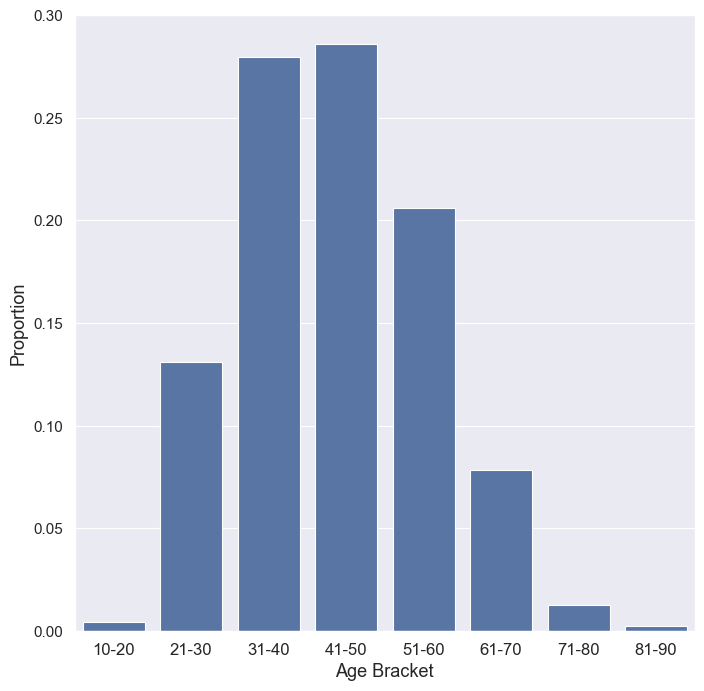

In [85]:
bins= [10,20,30,40,50,60,70,80,90]
labels = ['10-20','21-30','31-40','41-50','51-60', '61-70','71-80', '81-90']
df_train_eda['age_group'] = pd.cut(df_train_eda['age'], bins=bins, labels=labels, right=False)
plt.figure(figsize=(8,8))

tick_props, tick_names, var_sum = prop_(df_train_eda.age_group)
sns.countplot(data=df_train_eda, x ='age_group', color=base_color);
plt.ylabel('Proportion', fontsize=13)
plt.xlabel('Age Bracket', fontsize=13)
plt.yticks(tick_props * var_sum, tick_names, fontsize=11);
plt.xticks(fontsize=12);

The 10-20 age bracket contains 18 to 20 year olds as 18 is the legal age of employment.

### Distribution of applicant income 

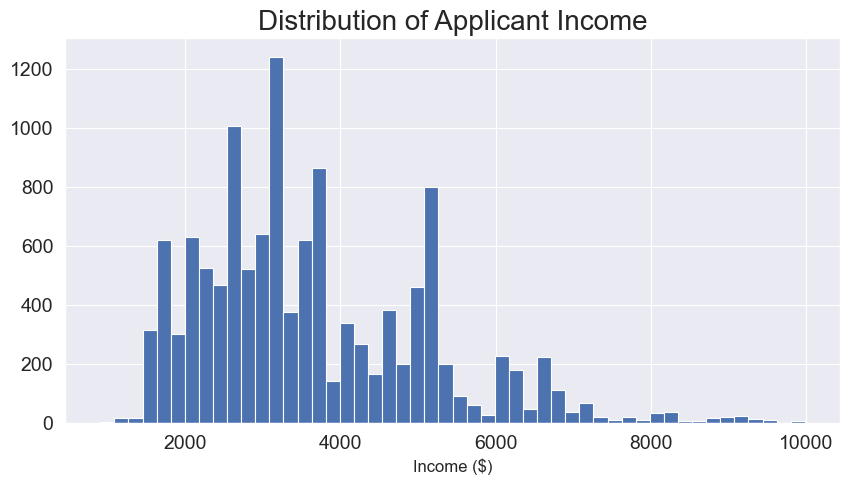

In [86]:
plt.figure(figsize=(10,5))
plt.hist(df_train_eda.income, color = base_color, bins = 50);
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Income ($)', fontsize=12)
plt.title('Distribution of Applicant Income', fontsize=20);

The distribution of applicant incomes is slightly skewed to the right suggesting that most applicants earn less 6000 per month.<br> The long tail of the histogram also suggests a few applicants earning far above the rest.

### Distribution of amount_requested

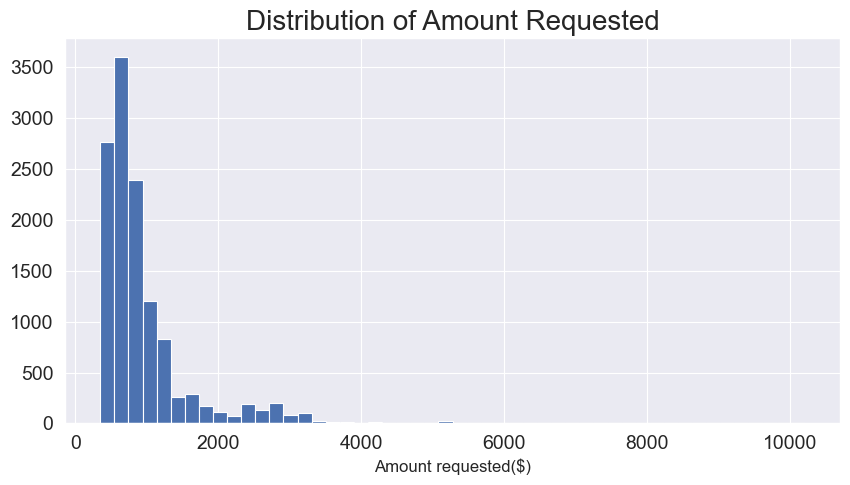

In [87]:
plt.figure(figsize=(10,5))
plt.hist(df_train_eda.amount_requested, color = base_color, bins = 50);
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Amount requested($)', fontsize=12)
plt.title('Distribution of Amount Requested', fontsize=20);

As early stated, the distribution of amount requested is very imbalanced as it is very skewed to the right suggesting a lot amounts requested falling below 2000

### Distribution of risk_score

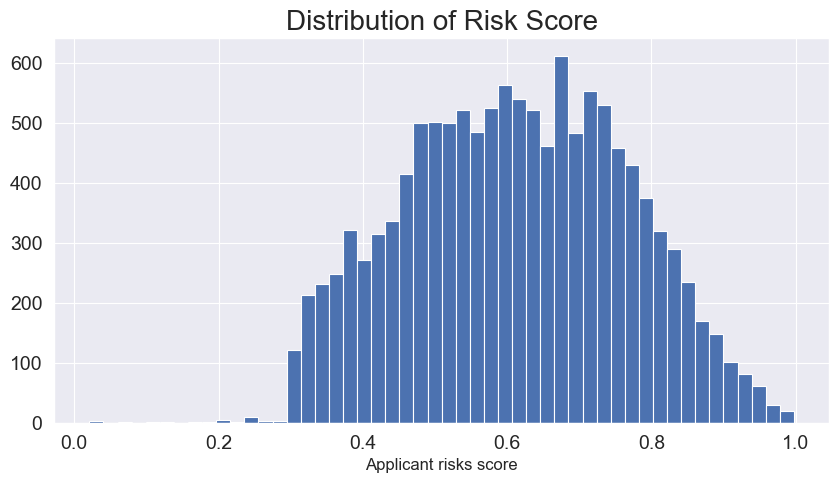

In [88]:
plt.figure(figsize=(10,5))
plt.hist(df_train_eda.risk_score_n, color = base_color, bins = 50);
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Applicant risks score', fontsize=12)
plt.title('Distribution of Risk Score', fontsize=20);

### Number of applicants that signed electronically.

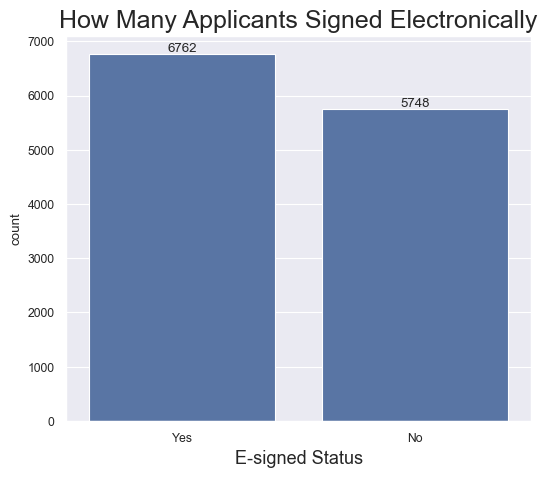

In [89]:
plt.figure(figsize=[6,5])

freq = df_train_eda['e_signed'].value_counts()
gen_order = freq.index

ax = sns.countplot(data = df_train_eda, x = 'e_signed', color=sns.color_palette()[0], order = gen_order)
plt.xticks()
plt.xlabel('E-signed Status', fontsize=13)
plt.title('How Many Applicants Signed Electronically', fontsize=18);
ax.bar_label(ax.containers[0], label_type='edge');

It can be inferred that most applicants have risk scores of 0.7 or less, making them less of a possible liability to the company and more eligible for loans.

## Bivariate Exploration

For this section, we are going to explore the relationships between the e_signed column and the numerical variables in the dataset.

In [90]:
# creating a variable that contains all applicants that signed electronically
yes_electronic = df_train_eda.query('e_signed == "Yes"')

### Relationship between applicant age and e_signed column

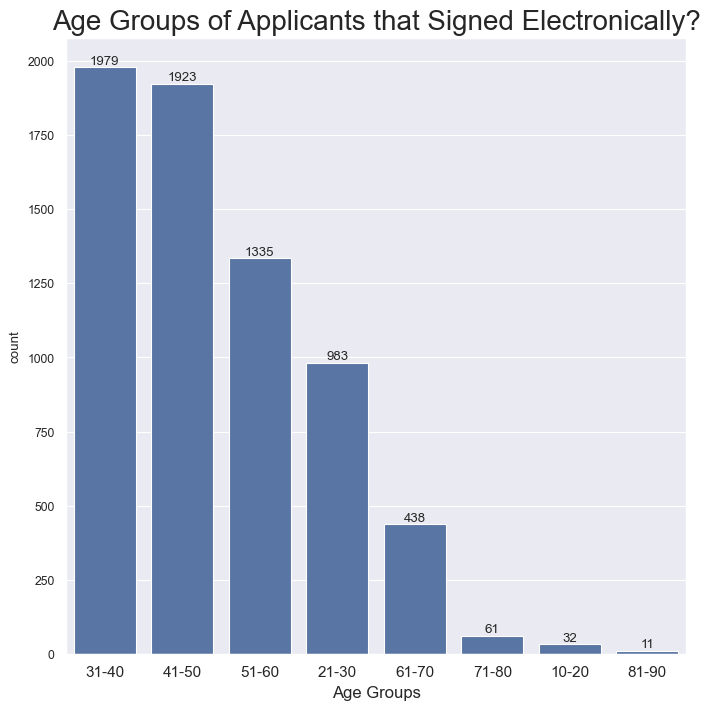

In [91]:
plt.figure(figsize=[8,8])

freq = yes_electronic['age_group'].value_counts()
gen_order = freq.index

ax = sns.countplot(data = yes_electronic, x = 'age_group', color=sns.color_palette()[0], order = gen_order)
plt.xticks(fontsize=11)
plt.xlabel('Age Groups', fontsize=12)
plt.title('Age Groups of Applicants that Signed Electronically?', fontsize=20);
ax.bar_label(ax.containers[0], label_type='edge');

### Relationship between amount requested and e_signed column

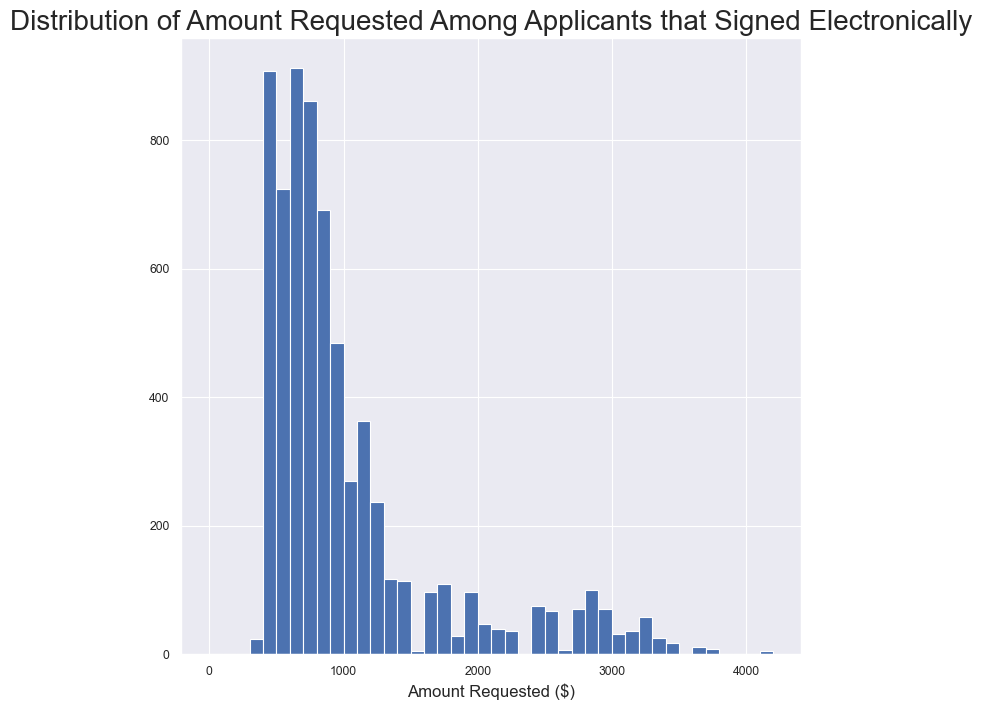

In [92]:
bins = np.arange(0, yes_electronic['amount_requested'].max()+100, 100)

plt.figure(figsize=[8, 8])
plt.hist(data = yes_electronic, x = 'amount_requested', bins = bins)
plt.xlabel('Amount Requested ($)', fontsize=12)
plt.title('Distribution of Amount Requested Among Applicants that Signed Electronically', fontsize=20)
plt.show()

It can be seen from the above histogram that we have a multimodal distribution that is strongly skewed to the right. Furthermore, applicants that signed electronically are mainly those that requested for a loan of about \\$1500 or less. It can therefore be inferred that applicants requesting for higher amounts are less likely to sign electronically.


### Relationship between applicant income and e_signed column

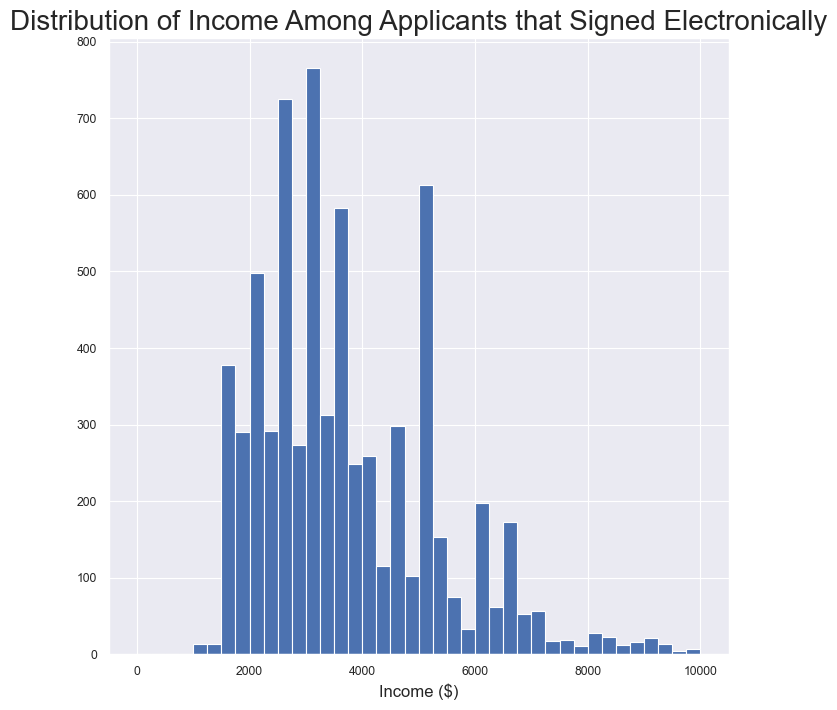

In [93]:
bins = np.arange(0, yes_electronic['income'].max()+250, 250)

plt.figure(figsize=[8, 8])
plt.hist(data = yes_electronic, x = 'income', bins = bins)
plt.xlabel('Income ($)', fontsize = 12)
plt.title('Distribution of Income Among Applicants that Signed Electronically', fontsize = 20)
plt.show()

We have a highly multimodal distribution that is also skewed to the right. Applicants that signed electronically are mainly those with an income of about \\$6000 or less. It can therefore be inferred that applicants with higher incomes are less likely to sign electronically.

### Relationship between risk_score and e_signed column

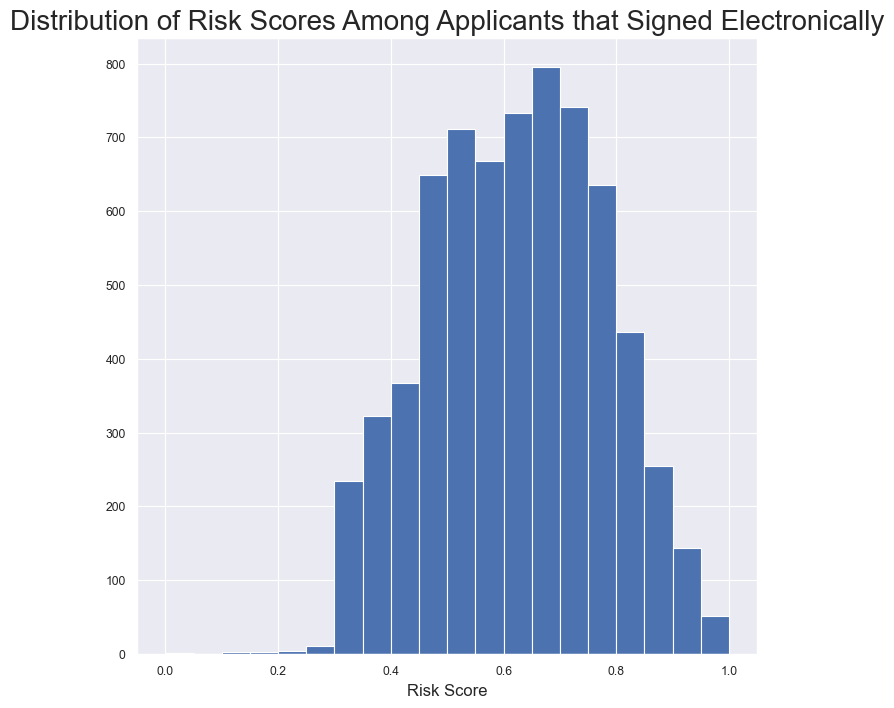

In [94]:
bins = np.arange(0, yes_electronic['risk_score_n'].max()+0.05, 0.05)

plt.figure(figsize=[8, 8])
plt.hist(data = yes_electronic, x = 'risk_score_n', bins = bins)
plt.xlabel('Risk Score', fontsize=12)
plt.title('Distribution of Risk Scores Among Applicants that Signed Electronically', fontsize=20)
plt.show()


The histogram is slightly skewed to the left suggesting that most of the applicants that signed up electronically are high risk individuals.

### How many home owners signed up electronically?

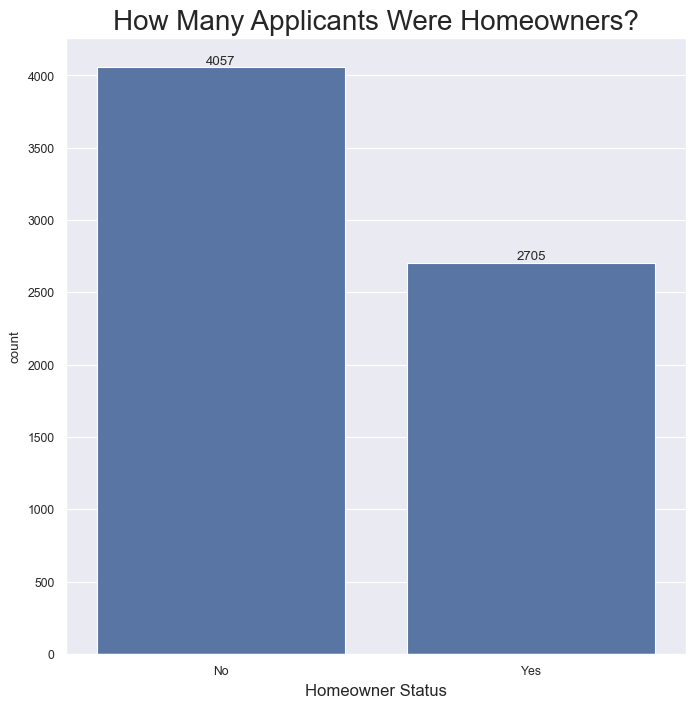

In [95]:
plt.figure(figsize=[8,8])

freq = yes_electronic['home_owner'].value_counts()
gen_order = freq.index

ax = sns.countplot(data = yes_electronic, x = 'home_owner', color=sns.color_palette()[0], order = gen_order)
plt.xticks()
plt.xlabel('Homeowner Status', fontsize=12)
plt.title('How Many Applicants Were Homeowners?', fontsize=20);
ax.bar_label(ax.containers[0], label_type='edge');

The bar chart shows that **4,059 (60%)** of all applicants who signed electronically were _not_ homeowners.

<a id='ml'></a>
## <u> Machine Learning Model

For the machine learning model, not all changes made for EDA will be applied here, so we preprocess the train and test datasets again.

In [96]:
df_train_copy = df_train.copy()

In [97]:
# Drop duplicate Entry IDs
df_train_copy.drop_duplicates('Entry_id', inplace=True)
df_train_copy = df_train_copy.reset_index(drop=True)

In [98]:
# Merge years_employed and months_employed
df_train_copy['total_months_employed'] = (df_train_copy['years_employed']*12) + df_train_copy['months_employed']
df_train_copy=df_train_copy.drop(['years_employed', 'months_employed'], axis=1)

In [99]:
# Merge personal_account_y and personal_account_m
df_train_copy['personal_account_duration'] = (df_train_copy['personal_account_y']*12) + df_train_copy['personal_account_m']
df_train_copy=df_train_copy.drop(['personal_account_y', 'personal_account_m'], axis=1)

For the model, we'll need only numerical variables, so string values of categorical variables won't work here. To fix this, we can OneHotEncode the categorical variable, or create dummy columns of the categoriacl variable. For this project, we'll be using dummy columns.

In [100]:
# To create dummy columns for the categorical variable pay_schedule
dummies = pd.get_dummies(df_train_copy['pay_schedule'])
dummies.head()

,bi-weekly,monthly,semi-monthly,weekly
0,1,0,0,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,1,0,0,0


In [101]:
# Merge dummy to original dataframe
df_train_dummy = pd.concat([df_train_copy, dummies],axis='columns')

# Drop original categorical variable and anyone of the dummy columns; 'monthly' in this case
df_train_dummy = df_train_dummy.drop(['pay_schedule', 'monthly'],axis='columns')
df_train_dummy.head()

,Entry_id,age,home_owner,income,current_address_year,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,...,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,total_months_employed,personal_account_duration,bi-weekly,semi-monthly,weekly
0,7629673,40,1,3135,3,1,550,36200,0.737398,0.903517,...,0.515977,0.580918,0.380918,10,1,36,30,1,0,0
1,5335819,33,0,3590,2,1,1100,53850,0.617361,0.857560,...,0.665523,0.744634,0.744634,12,0,60,98,0,1,0
2,8492423,21,0,2303,8,1,600,74850,0.677109,0.758765,...,0.664762,0.592556,0.492556,6,1,60,86,0,0,1
3,7948313,26,0,2795,4,1,800,50800,0.738055,0.873204,...,0.700392,0.584130,0.684130,14,1,48,73,1,0,0
4,4297036,43,0,5000,1,1,1100,69100,0.798303,0.841747,...,0.568787,0.525905,0.725905,5,1,24,25,1,0,0


###### Perform similar operations on the test data

In [102]:
df_test_copy = df_test.copy()

In [103]:
df_test_copy['total_months_employed'] = (df_test_copy['years_employed']*12) + df_test_copy['months_employed']
df_test_copy=df_test_copy.drop(['years_employed', 'months_employed'], axis=1)

In [104]:
df_test_copy['personal_account_duration'] = (df_test_copy['personal_account_y']*12) + df_test_copy['personal_account_m']
df_test_copy=df_test_copy.drop(['personal_account_y', 'personal_account_m'], axis=1)

In [105]:
dummies = pd.get_dummies(df_test_copy['pay_schedule'])
dummies.head()

,bi-weekly,monthly,semi-monthly,weekly
0,0,0,0,1
1,0,0,0,1
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [106]:
df_test_dummy = pd.concat([df_test_copy, dummies],axis='columns')
df_test_dummy = df_test_dummy.drop(['pay_schedule', 'monthly'],axis='columns')
df_test_dummy.head()

,Entry_id,age,home_owner,income,current_address_year,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,total_months_employed,personal_account_duration,bi-weekly,semi-monthly,weekly
0,3560428,61,0,3180,3,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72,86,0,0,1
1,6934997,23,0,1540,0,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6,19,0,0,1
2,5682812,40,0,5230,1,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72,86,1,0,0
3,6493191,32,0,5260,3,1,1150,64050,0.652429,0.802433,0.593816,0.560389,0.569459,0.369459,3,3,49,0,1,0
4,8990111,61,1,3270,0,1,400,61700,0.659736,0.937287,0.852323,0.785698,0.632466,0.732466,7,48,40,1,0,0


### Using cross validation with LighthGBM

In [107]:
df_train_dummy['kfold'] = -1

In [108]:
kf = KFold(n_splits = 6, shuffle = True, random_state = 50)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X = df_train_dummy)):
    df_train_dummy.loc[valid_indices, 'kfold'] = fold

In [109]:
useful_features = df_train_dummy.columns.difference(['Entry_id', 'risk_score_4', 'risk_score_5',
                                                     'e_signed', 'total_months_employed','kfold'])
test = df_test_dummy[df_test_dummy.columns.difference(['Entry_id','risk_score_4', 'risk_score_5',
                                                       'e_signed', 'total_months_employed', 'kfold'])]
predictions = []

In [110]:
lgb_score = []
for fold in range(6):
    x_train = df_train_dummy[df_train_dummy['kfold'] != fold].reset_index(drop = True)
    x_valid = df_train_dummy[df_train_dummy['kfold'] == fold].reset_index(drop = True)
    
    y_train = x_train['e_signed']
    y_valid = x_valid['e_signed']
    
    x_train = x_train[useful_features]
    x_valid = x_valid[useful_features]

    
    model = LGBMClassifier(random_state = 42, n_jobs = -1, n_estimators = 1474, learning_rate = 0.03372831097120445,
                           colsample_bytree = 0.7257259813712209, max_depth = 6)
    model.fit(x_train, y_train, early_stopping_rounds = 300, eval_set = [(x_valid, y_valid)], verbose = 1000)
    y_pred = model.predict_proba(x_valid)
    test_pred = model.predict_proba(test)
    predictions.append(test_pred[:, -1])
    score = roc_auc_score( y_valid, y_pred[:,-1])
    lgb_score.append(score)
    print(fold, score)
print(np.mean(lgb_score))

0 0.7086579515760892
1 0.6971319318720783
2 0.6928242225592235
3 0.7170228623150022
4 0.7069782802968488
5 0.7075509259259259
0.7050276957575279


In [111]:
final_prediction = np.mean(np.column_stack(predictions), axis = 1)

final_prediction = np.where(final_prediction >= 0.5, 1,0)

Entry_id = df_test[['Entry_id']]
e_signed = pd.DataFrame({'e_signed' : final_prediction})

lgbm_cv_sub = pd.concat([Entry_id, e_signed], axis = 1)

In [112]:
lgbm_cv_sub.to_csv('lgbm_CV_sub.csv', index = False)

<a id='conclusions'></a>
## <u> Conclusion

After carrying out this exploratory data analysis, the following conclusions were made:<br>
1. Most applicants fall within the age brackets of **41-50(3,575/28.58%)** and **31-40(3,499/27.97%)**
2. **1979** of all applicants who signed electronically are in the 31-40 age group, making it the highest occurring age group. 
3. **6,766/54.06%** of all applicants signed electronically.
4. Applicants requesting for higher amounts (>\\$1500) are less likely to sign electronically.
5. Applicants with higher incomes are less likely to sign electronically.
6. **4,059 (60%)** of all applicants who signed electronically were _not_ homeowners.

<a id='references'></a>
## <u> References

- [Stackoverflow](https://stackoverflow.com/)
- [Youtube](https://youtube.com)
- [Lightgbm](https://lightgbm.readthedocs.io/en/v3.3.2/)